# Global Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import pandas as pd
from matplotlib import style
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import random as rn
import cv2                  
import numpy as np  
from tqdm import tqdm
from random import shuffle  
from PIL import Image
from google.colab import drive
import zipfile
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from collections import Counter
from PIL import UnidentifiedImageError
!pip install pyheif
import pyheif
from PIL import Image
from keras.callbacks import ReduceLROnPlateau


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Global Variables

In [47]:
IMG_SIZE=150
zip_path = '/content/drive/MyDrive/Flowers-20230527T190058Z-001.zip'
TRAIN_DIR = '/content/flowers/Flowers/Training_set'
TEST_DIR = '/content/flowers/Flowers/Test_set'


# Data preparation

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/flowers')

os.chdir('/content/flowers')

In [5]:
## Disclaimer : you have .heic images, these are not supported by PIL and das why i used pyheif library

In [6]:
def make_train(train_dir):
    train_data = []
    train_labels = []
    for label in os.listdir(train_dir):
        label_dir = os.path.join(train_dir, label)
        for image_name in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_name)
            try:
                if image_path.endswith(".heic"):
                    heif_file = pyheif.read(image_path)
                    image = Image.frombytes(
                        heif_file.mode, 
                        heif_file.size, 
                        heif_file.data,
                        "raw",
                        heif_file.mode,
                        heif_file.stride,
                    )
                else:
                    image = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
                image = img_to_array(image)
                train_data.append(image)
                train_labels.append(label)
            except UnidentifiedImageError:
                print(f"Error: Unable to identify image file {image_path}")
                continue
    return train_data, train_labels


In [7]:
def make_test(test_dir):
    test_data = []
    test_labels = []
    for label in os.listdir(test_dir):
        label_dir = os.path.join(test_dir, label)
        for image_name in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_name)a
            try:
                if image_path.endswith(".heic"):
                    heif_file = pyheif.read(image_path)
                    image = Image.frombytes(
                        heif_file.mode, 
                        heif_file.size, 
                        heif_file.data,
                        "raw",
                        heif_file.mode,
                        heif_file.stride,
                    )
                else:
                    image = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
                image = img_to_array(image)
                test_data.append(image)
                test_labels.append(label)
            except UnidentifiedImageError:
                print(f"Error: Unable to identify image file {image_path}")
                continue
    return test_data, test_labels

In [8]:
train_data, train_labels = make_train(TRAIN_DIR)
test_data, test_labels = make_test(TEST_DIR)


## Data Viz

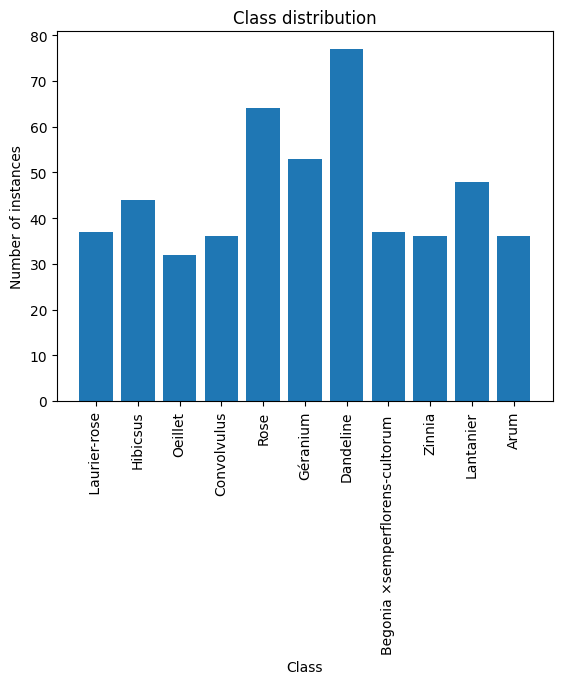

In [9]:
# Nchoufo class distribution of train set
class_counts = Counter(train_labels)

plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of instances')
plt.title('Class distribution')
plt.show()

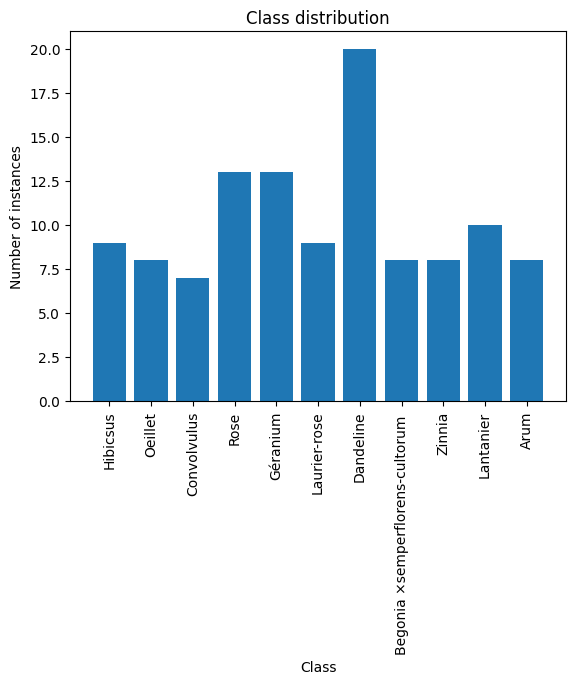

In [10]:
# Nchoufo class distribution of test set
class_counts = Counter(test_labels)

plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of instances')
plt.title('Class distribution')
plt.show()

In [11]:
## Disclaimer : first thing you notice here is that test and train set do not have the same labels, so we only keep common labels

In [12]:
train_labels_set = set(train_labels)
test_labels_set = set(test_labels)
common_labels = train_labels_set.intersection(test_labels_set)

train_data_common = []
train_labels_common = []
for data, label in zip(train_data, train_labels):
    if label in common_labels:
        train_data_common.append(data)
        train_labels_common.append(label)

#  keep only common labels
test_data_common = []
test_labels_common = []
for data, label in zip(test_data, test_labels):
    if label in common_labels:
        test_data_common.append(data)
        test_labels_common.append(label)

train_data = train_data_common
train_labels = train_labels_common
test_data = test_data_common
test_labels = test_labels_common


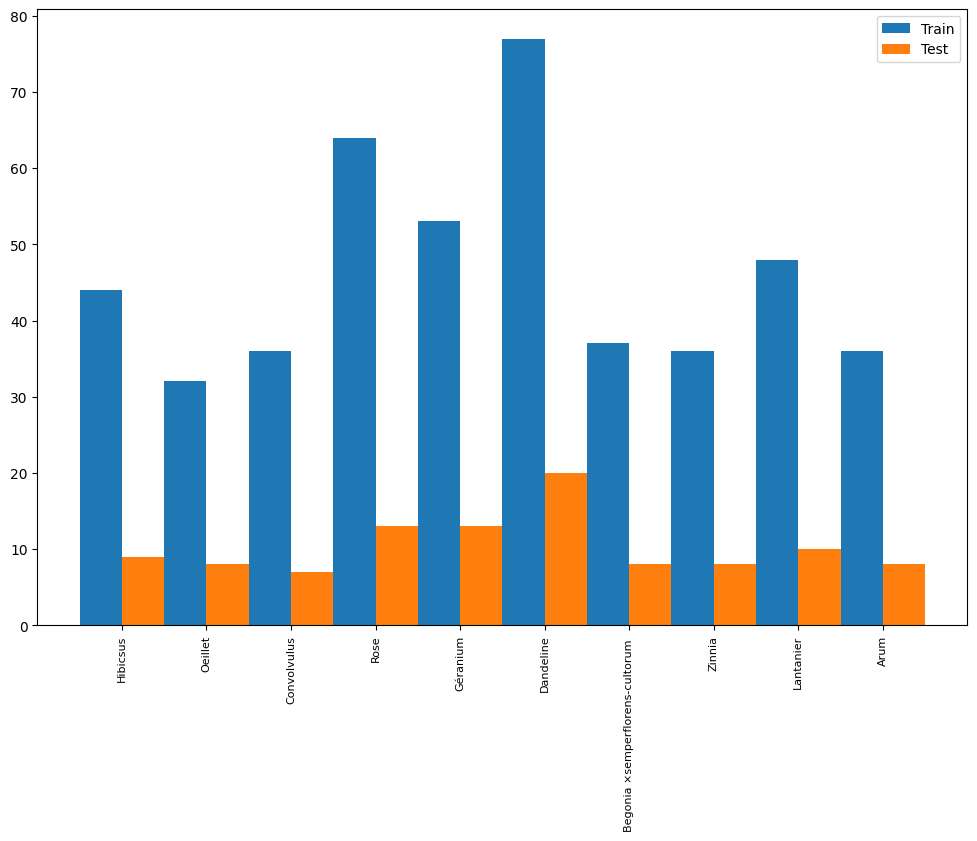

In [13]:
import matplotlib.pyplot as plt
from collections import Counter

train_counter = Counter(train_labels)
train_classes = list(train_counter.keys())
train_counts = list(train_counter.values())

test_counter = Counter(test_labels)
test_classes = list(test_counter.keys())
test_counts = list(test_counter.values())

x = range(len(train_classes))
width = 0.5
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(x, train_counts, width, label="Train")
ax.bar([i + width for i in x], test_counts, width, label="Test")
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(train_classes)
ax.legend()
plt.xticks(fontsize=8)
plt.xticks(rotation=90)
plt.show()


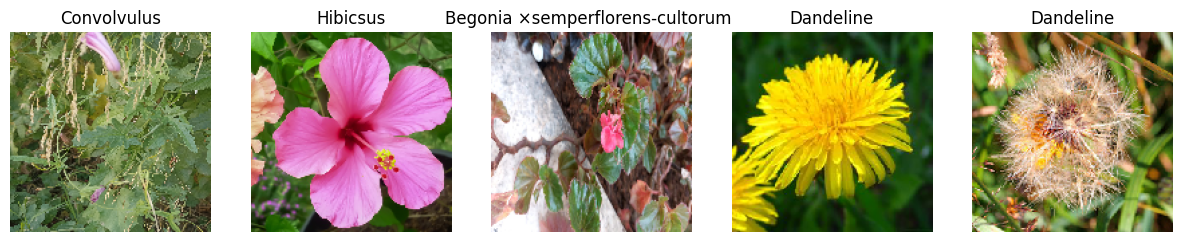

In [14]:
# Nchoufo un petit echantillon de notre train set
num_instances = 5

indices = np.random.choice(len(train_data), size=num_instances, replace=False)

fig, axes = plt.subplots(1, num_instances, figsize=(15, 5))

for i, index in enumerate(indices):
    image = train_data[index]
    label = train_labels[index]
    axes[i].imshow(image.astype('uint8'))
    axes[i].set_title(label)
    axes[i].axis('off')

plt.show()

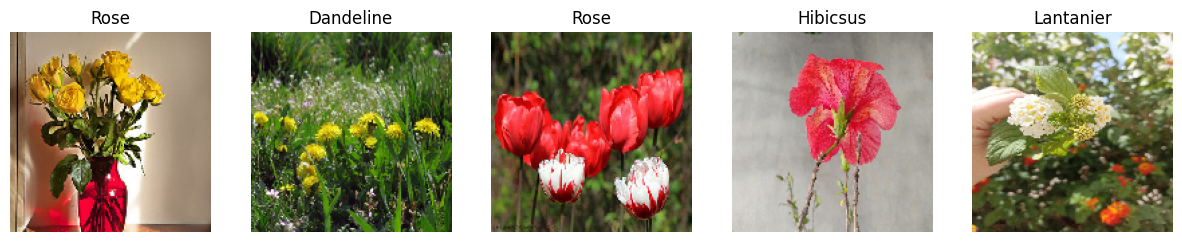

In [15]:
# Nchoufo un petit echantillon de notre test set
num_instances = 5

indices = np.random.choice(len(test_data), size=num_instances, replace=False)

fig, axes = plt.subplots(1, num_instances, figsize=(15, 5))

for i, index in enumerate(indices):
    image = test_data[index]
    label = test_labels[index]
    axes[i].imshow(image.astype('uint8'))
    axes[i].set_title(label)
    axes[i].axis('off')

plt.show()

## Preprocessing

In [16]:
# lazem i normalize the pixels vals to reduce computational force
train_data = [x / 255.0 for x in train_data]
test_data = [x / 255.0 for x in test_data]


# our rn works with numpy array yetsemaaaa we transform
train_data = np.array(train_data)
test_data = np.array(test_data)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# basic label encoder
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.transform(test_labels)

# One hot encode  zi labels, jadwal fih 1 in the right class
num_classes = len(label_encoder.classes_)
train_labels = to_categorical(train_labels, num_classes=num_classes)
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [17]:
# hedi to use later on predictions, besh manensach.
def decode_predictions(predictions, label_encoder):
    class_indices = np.argmax(predictions, axis=1)
    class_names = label_encoder.inverse_transform(class_indices)
    return class_names
'''
predictions = model.predict(test_data)
predicted_class_names = decode_predictions(predictions, label_encoder)
'''

'\npredictions = model.predict(test_data)\npredicted_class_names = decode_predictions(predictions, label_encoder)\n'

In [18]:
np.random.seed(42)
rn.seed(42)

## Making model

In [19]:
train_data = tf.convert_to_tensor([tf.convert_to_tensor(tf.image.resize(x, (IMG_SIZE, IMG_SIZE))) for x in train_data])
test_data = tf.convert_to_tensor([tf.convert_to_tensor(tf.image.resize(x, (IMG_SIZE, IMG_SIZE))) for x in test_data])

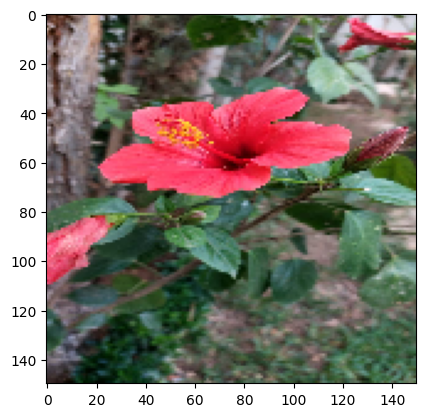

In [20]:
import matplotlib.pyplot as plt

image = train_data[0]

image = image.numpy()

plt.imshow(image)
plt.show()


In [90]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10, activation = "softmax"))

In [91]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])


In [92]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 18, 18, 96)      

In [93]:
datagen = ImageDataGenerator(
featurewise_center=False,  # set input mean to 0 over the dataset
samplewise_center=False,  # set each sample mean to 0
featurewise_std_normalization=False,  # divide inputs by std of the dataset
samplewise_std_normalization=False,  # divide each input by its std
zca_whitening=False,  # apply ZCA whitening
rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
zoom_range = 0.1, # Randomly zoom image 
width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
horizontal_flip=True,  # randomly flip images
vertical_flip=False  # randomly flip images
)

datagen.fit(train_data)

augmented_data = datagen.flow(train_data, train_labels, batch_size=32)


In [96]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10),
    
    ModelCheckpoint('best_model.h5', save_best_only=True),
    
    ReduceLROnPlateau(monitor='val_loss',patience=3,verbose=1,factor=0.1)
]


In [97]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(augmented_data,
                    validation_data=(test_data, test_labels),
                    epochs=100,
                    callbacks=callbacks)


Epoch 1/100
15/15 [==============================] - 39s 3s/step - loss: 2.0260 - accuracy: 0.2419 - val_loss: 1.9712 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 2/100
15/15 [==============================] - 42s 3s/step - loss: 1.9014 - accuracy: 0.3348 - val_loss: 1.8696 - val_accuracy: 0.3077 - lr: 0.0010
Epoch 3/100
15/15 [==============================] - 36s 2s/step - loss: 1.7773 - accuracy: 0.3499 - val_loss: 1.7824 - val_accuracy: 0.3365 - lr: 0.0010
Epoch 4/100
15/15 [==============================] - 34s 2s/step - loss: 1.6725 - accuracy: 0.4255 - val_loss: 1.9337 - val_accuracy: 0.3077 - lr: 0.0010
Epoch 5/100
15/15 [==============================] - 34s 2s/step - loss: 1.7214 - accuracy: 0.3650 - val_loss: 1.6810 - val_accuracy: 0.4135 - lr: 0.0010
Epoch 6/100
15/15 [==============================] - 37s 2s/step - loss: 1.6346 - accuracy: 0.4017 - val_loss: 1.7318 - val_accuracy: 0.3942 - lr: 0.0010
Epoch 7/100
15/15 [==============================] - 34s 2s/step - loss: 1.5

In [98]:
model.save('model.h5')

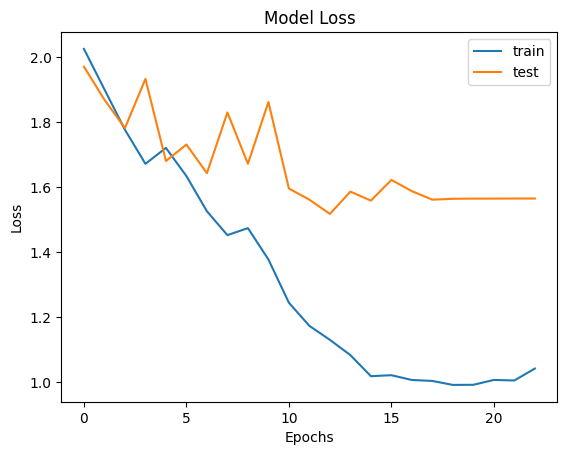

In [99]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

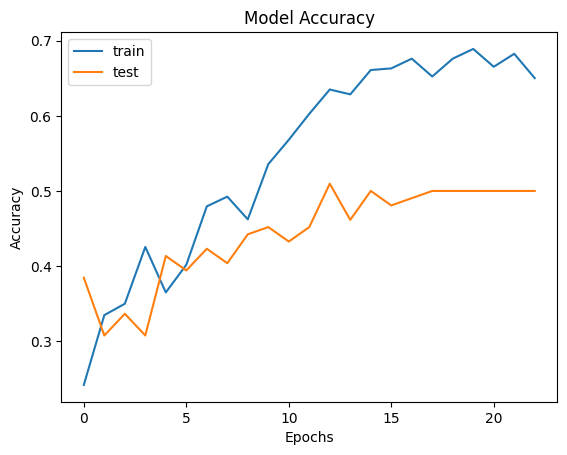

In [100]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [101]:
from sklearn.metrics import classification_report

model.evaluate(test_data, test_labels)

4/4 [==============================] - 2s 392ms/step - loss: 1.5657 - accuracy: 0.5000


[1.5656808614730835, 0.5]

In [102]:
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

report = classification_report(true_classes, predicted_classes)
print(report)

4/4 [==============================] - 2s 375ms/step
              precision    recall  f1-score   support

           0       0.40      0.50      0.44         8
           1       0.67      0.75      0.71         8
           2       0.86      0.86      0.86         7
           3       0.83      0.75      0.79        20
           4       0.25      0.23      0.24        13
           5       0.40      0.89      0.55         9
           6       0.29      0.20      0.24        10
           7       0.17      0.12      0.14         8
           8       0.60      0.46      0.52        13
           9       0.20      0.12      0.15         8

    accuracy                           0.50       104
   macro avg       0.47      0.49      0.46       104
weighted avg       0.50      0.50      0.49       104



In [ ]:
## This model is meh so we go to betteh thingy.

## Improving Model

In [28]:
## This time i use transfer learning from a pretrained model vgg16 psk hayel and i fine tune it ofc 

from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)

predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


58889256/58889256 [==============================] - 0s 0us/step


### Data augmentation

In [29]:
datagen = ImageDataGenerator(
featurewise_center=False,  # set input mean to 0 over the dataset
samplewise_center=False,  # set each sample mean to 0
featurewise_std_normalization=False,  # divide inputs by std of the dataset
samplewise_std_normalization=False,  # divide each input by its std
zca_whitening=False,  # apply ZCA whitening
rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
zoom_range = 0.1, # Randomly zoom image 
width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
horizontal_flip=True,  # randomly flip images
vertical_flip=False  # randomly flip images
)

datagen.fit(train_data)

augmented_data = datagen.flow(train_data, train_labels, batch_size=32)




### Callbacks

In [30]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    # stop training when the validation loss stops improving
    EarlyStopping(monitor='val_loss', patience=10),
    
    # save the best model during training
    ModelCheckpoint('best_model.h5', save_best_only=True),
    
    # reduce the learning rate when the validation loss stops improving
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
]



### Setting best params

In [31]:
METRIC = ['accuracy']
LOSS = 'categorical_crossentropy'
optim = Adam(lr=0.001,clipvalue=1.0 )
epochs = 100 
batch_size=32

In [32]:
model.compile(optimizer=optim,loss=LOSS,metrics= METRIC)


In [33]:
History = model.fit(augmented_data,
                              epochs = epochs, validation_data = (test_data,test_labels),
                              verbose = 1, 
                              callbacks=callbacks,
                              batch_size = batch_size,
                              shuffle = True
                    )

Epoch 1/100
15/15 [==============================] - 172s 11s/step - loss: 2.1188 - accuracy: 0.2570 - val_loss: 1.8281 - val_accuracy: 0.3942 - lr: 0.0010
Epoch 2/100
15/15 [==============================] - 168s 12s/step - loss: 1.6100 - accuracy: 0.4622 - val_loss: 1.5680 - val_accuracy: 0.5673 - lr: 0.0010
Epoch 3/100
15/15 [==============================] - 167s 12s/step - loss: 1.3650 - accuracy: 0.5594 - val_loss: 1.4183 - val_accuracy: 0.5288 - lr: 0.0010
Epoch 4/100
15/15 [==============================] - 178s 12s/step - loss: 1.1710 - accuracy: 0.6674 - val_loss: 1.3586 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 5/100
15/15 [==============================] - 185s 12s/step - loss: 1.0455 - accuracy: 0.7019 - val_loss: 1.3053 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 6/100
15/15 [==============================] - 174s 12s/step - loss: 0.9860 - accuracy: 0.6868 - val_loss: 1.2878 - val_accuracy: 0.6346 - lr: 0.0010
Epoch 7/100
15/15 [==============================] - 161s 11s/st

In [34]:
model.save('model-augmented.h5')

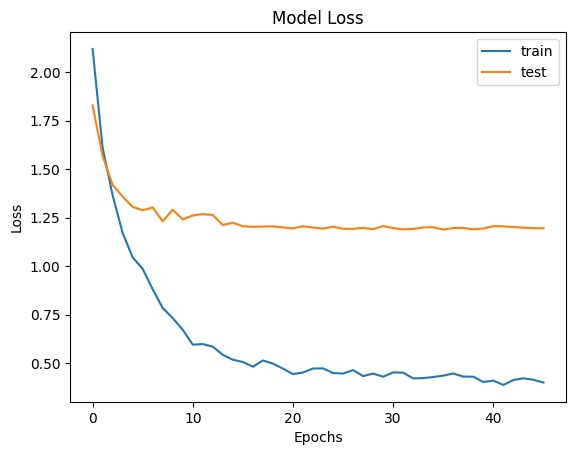

In [45]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

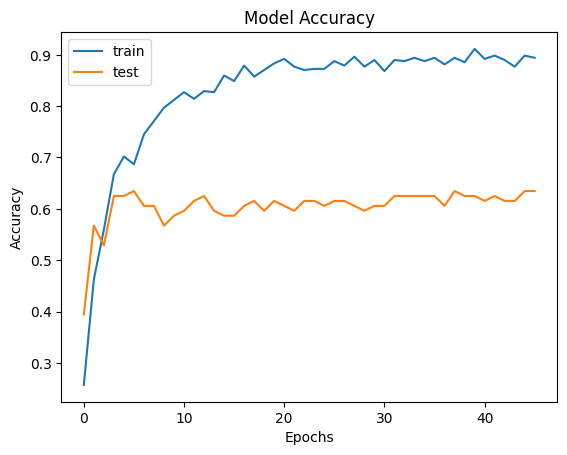

In [37]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

4/4 [==============================] - 31s 6s/step


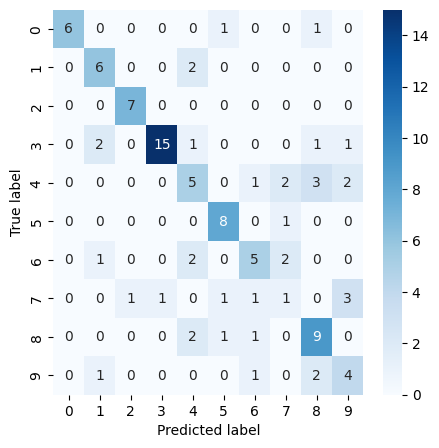

In [38]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


y_true = np.argmax(test_labels, axis=1)

y_pred = model.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [39]:
from sklearn.metrics import classification_report

model.evaluate(test_data, test_labels)

4/4 [==============================] - 28s 6s/step - loss: 1.1950 - accuracy: 0.6346


[1.1949522495269775, 0.6346153616905212]

In [40]:
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

report = classification_report(true_classes, predicted_classes)
print(report)

4/4 [==============================] - 29s 6s/step
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.60      0.75      0.67         8
           2       0.88      1.00      0.93         7
           3       0.94      0.75      0.83        20
           4       0.42      0.38      0.40        13
           5       0.73      0.89      0.80         9
           6       0.56      0.50      0.53        10
           7       0.17      0.12      0.14         8
           8       0.56      0.69      0.62        13
           9       0.40      0.50      0.44         8

    accuracy                           0.63       104
   macro avg       0.62      0.63      0.62       104
weighted avg       0.64      0.63      0.63       104



4/4 [==============================] - 33s 7s/step


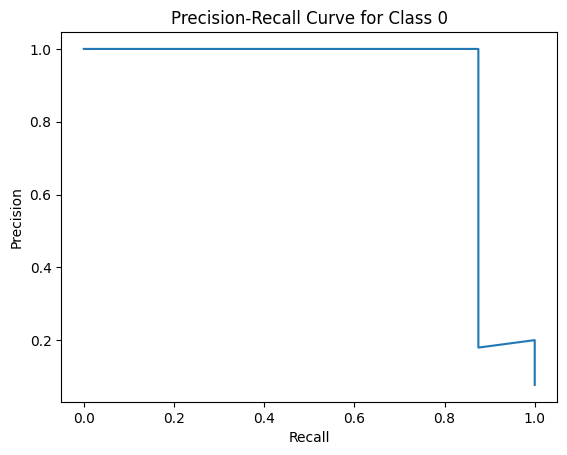

In [43]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Choose the class to plot the precision-recall curve for
class_index = 0

# Binarize the test labels
test_labels_binary = label_binarize(test_labels, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Make predictions on the test data
predictions = model.predict(test_data)

# Calculate precision and recall for the chosen class
precision, recall, _ = precision_recall_curve(test_labels_binary[:, class_index], predictions[:, class_index])

# Plot the precision-recall curve for the chosen class
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve for Class {class_index}')
plt.show()


4/4 [==============================] - 33s 7s/step


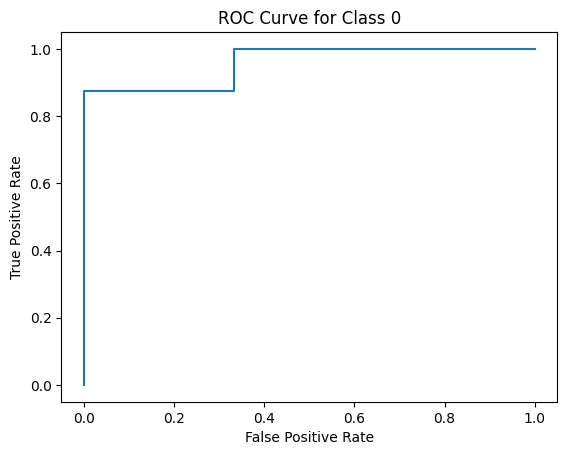

In [44]:
from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Choose the class to plot the ROC curve for
class_index = 0

# Binarize the test labels
test_labels_binary = label_binarize(test_labels, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Make predictions on the test data
predictions = model.predict(test_data)

# Calculate false positive rate and true positive rate for the chosen class
fpr, tpr, _ = roc_curve(test_labels_binary[:, class_index], predictions[:, class_index])

# Plot the ROC curve for the chosen class
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for Class {class_index}')
plt.show()


In [67]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

def load_images(directory):
    images = []
    for image_name in os.listdir(directory):
        image_path = os.path.join(directory, image_name)
        image = load_img(image_path)
        image_array = img_to_array(image)
        images.append(image_array)
    return images


In [68]:
PRED_DIR = '/content/flowers/Flowers/Prediction'
pred_data= load_images(PRED_DIR)

In [70]:
pred_data = [x / 255.0 for x in pred_data]
pred_data = np.array(pred_data)

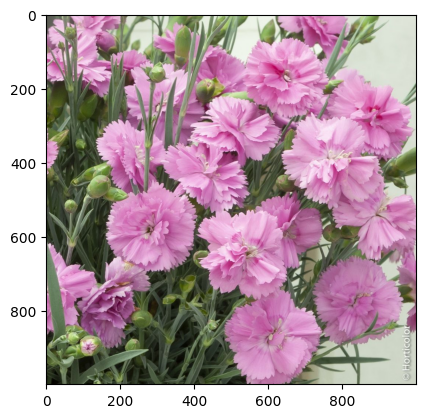

In [71]:
import matplotlib.pyplot as plt

# Select an image from train_data
image = pred_data[0]

# Convert the image tensor to a NumPy array
#image = image.numpy()

# Plot the image using matplotliba
plt.imshow(image)
plt.show()


In [73]:
pred_data = tf.convert_to_tensor([tf.convert_to_tensor(tf.image.resize(x, (IMG_SIZE, IMG_SIZE))) for x in pred_data])

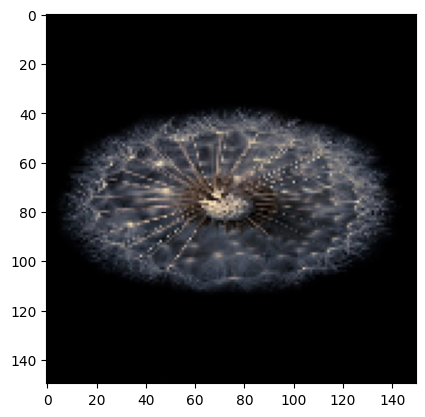

In [87]:
import matplotlib.pyplot as plt

# Select an image from train_data
image = pred_data[10]

# Convert the image tensor to a NumPy array
#image = image.numpy()

# Plot the image using matplotliba
plt.imshow(image)
plt.show()


1/1 [==============================] - 4s 4s/step


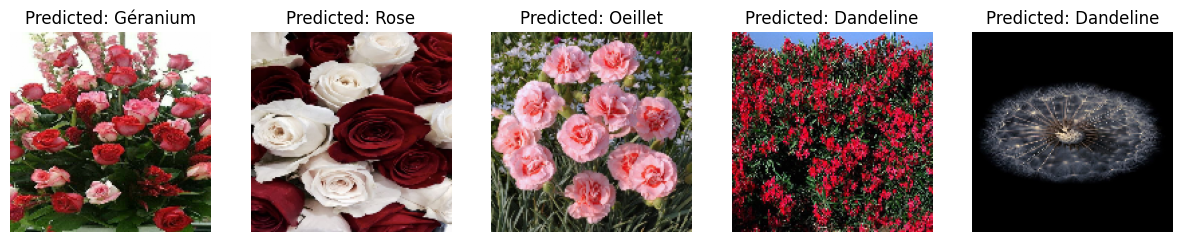

In [77]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Make predictions on the pred_data
predictions = model.predict(pred_data)
predicted_classes = np.argmax(predictions, axis=1)

# Decode the predicted class indices to get the real label names
predicted_labels = label_encoder.inverse_transform(predicted_classes)

# Choose a random batch of 5 images and their predictions
indices = np.random.choice(range(len(pred_data)), size=5, replace=False)
images = tf.gather(pred_data, indices)
predicted_labels = predicted_labels[indices]

# Plot the images and their predicted labels
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, (image, predicted_label) in enumerate(zip(images, predicted_labels)):
    axes[i].imshow(image.numpy())
    axes[i].set_title(f'Predicted: {predicted_label}')
    axes[i].axis('off')
plt.show()


In [80]:
test_data.shape

TensorShape([104, 150, 150, 3])

In [88]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def plot_correctly_classified_images(test_data, test_labels, model, label_encoder):
    # Make predictions on the test data
    predictions = model.predict(test_data)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(test_labels, axis=1)

    # Decode the predicted class indices to get the real label names
    predicted_labels = label_encoder.inverse_transform(predicted_classes)

    # Find the indices of correctly classified images
    correct_indices = np.where(predicted_classes == true_classes)[0]

    # Choose a random batch of 5 correctly classified images and their predictions
    indices = np.random.choice(correct_indices, size=5, replace=False)
    images = tf.gather(test_data, indices)
    predicted_labels = predicted_labels[indices]

    # Plot the images and their predicted labels
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i, (image, predicted_label) in enumerate(zip(images, predicted_labels)):
        axes[i].imshow(image.numpy())
        axes[i].set_title(f'Predicted: {predicted_label}')
        axes[i].axis('off')
    plt.show()

def plot_misclassified_images(test_data, test_labels, model, label_encoder):
    # Make predictions on the test data
    predictions = model.predict(test_data)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(test_labels, axis=1)

    # Decode the predicted class indices to get the real label names
    predicted_labels = label_encoder.inverse_transform(predicted_classes)

    # Find the indices of misclassified images
    incorrect_indices = np.where(predicted_classes != true_classes)[0]

    # Choose a random batch of 5 misclassified images and their predictions
    indices = np.random.choice(incorrect_indices, size=5, replace=False)
    images = tf.gather(test_data, indices)
    predicted_labels = predicted_labels[indices]

    # Plot the images and their predicted labels
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i, (image, predicted_label) in enumerate(zip(images, predicted_labels)):
        axes[i].imshow(image.numpy())
        axes[i].set_title(f'Predicted: {predicted_label}')
        axes[i].axis('off')
    plt.show()


4/4 [==============================] - 30s 6s/step


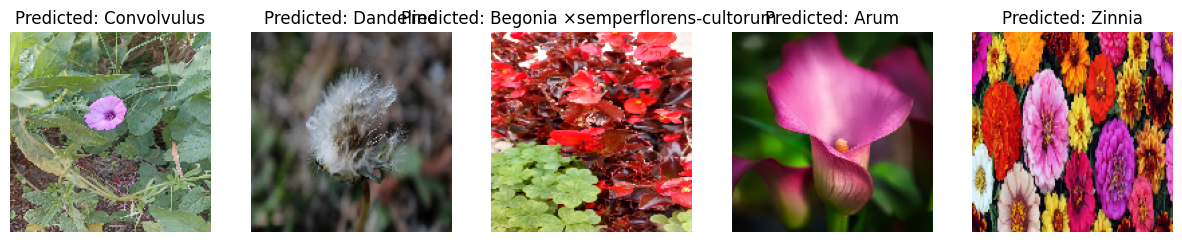

In [89]:
plot_correctly_classified_images(test_data, test_labels, model, label_encoder)

4/4 [==============================] - 28s 7s/step


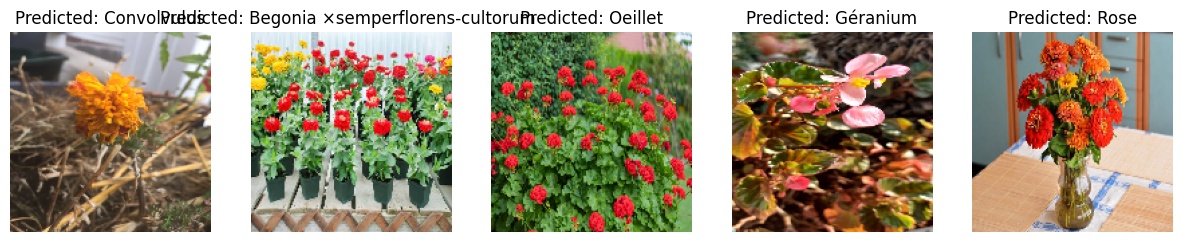

In [86]:
plot_misclassified_images(test_data, test_labels, model, label_encoder)